In [ ]:
import numpy as np
import h5py
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure, cm
import os, sys, time
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset

import umap

In [2]:
dtype = torch.float
device = torch.device("mps")

transform = transforms.ToTensor()

In [3]:
path = '/Users/ognjen/Writing/BGI/Data'
filename = 'stereo_seq_olfactory_bulb_bin140_annotation.h5ad'

In [4]:
def msError(original, prediction):
    error = np.sum((np.array(original) - np.array(prediction))**2, axis = 1) / original.shape[1]
    # print(error)
    return error

In [5]:
def normalize(V):
    V_normalized = (V - V.min(axis=0))/(V.max(axis=0) - V.min(axis=0))
    return V_normalized

In [6]:
def umap_analysis(X_test, n_neighbors = 5, min_dist = 0.5):

    if useGPU:
        test_X = X_test.to(device)  

    X_embd = model.encoder(test_X)
    X_embd = X_embd.detach().cpu()
    fit = umap.UMAP(n_neighbors=n_neighbors, min_dist = min_dist)
    X_values_2D = fit.fit_transform(X_embd)
    
    return X_values_2D

In [7]:
def loadData(filenam, path):
    data = {}
    
    temp_dict = {}
    f = h5py.File(os.path.join(path, filename), "r")
    
    print("Keys: %s" % f.keys())
    
    keys = f.keys()
            
    for i, k in enumerate(keys):
        print(i, type(f[k]))
        if i < 1:
            data[k] = f[k][()]
            print(data[k].shape)
        else:
            data[k] = f[k]
    
    X = data['X']

    return data, X

In [8]:
def extract_cell_families(data):
    cellF = []
    for ct in data['obs']['cell type']['codes'][0:]:
        if ct not in cellF:
            cellF.append(ct)

    cell_types = data['obs']['cell type']['codes'][0:]

    return cellF, cell_types

In [9]:
def shuffle_data(X, cell_types, cellF):

    # shuffling cells
    pc = np.random.permutation(len(cell_types))
    shuffled_cell_types = cell_types[pc]
    
    X = X[pc, :]
    
    
    # shuffling genes
    pg = np.random.permutation(X.shape[1])
    X_shuffled = X[:, pg]
    X = X_shuffled

    catIndex = {}

    for cat in cellF:
        catIndex[cat] = []
        catIndex[cat] = np.where(shuffled_cell_types[0:]==cat)[0]
        
    # print(catIndex.keys())
    
    return X, shuffled_cell_types, catIndex

In [10]:
def splitData(cellF, catIndex, val_split=0.1):

    val_split = 0.1
    
    training_indices = []
    validation_indices = []
    testing_indices = []
    
    sm = 0
    vtsm = 0
    
    for cat in cellF:
        cl = len(catIndex[cat])
        # print(len(catIndex[cat][0:int(cl*(1-2*val_split))]))
        training_indices.extend(catIndex[cat][0:int(cl*(1 - 2*val_split))])
        
        len_tr_indices = len(catIndex[cat][0:int(cl*(1 - 2*val_split))])
        vtsm = cl - len_tr_indices
        # print(cl, len_tr_indices, vtsm)
        
        val_len = int(np.ceil(vtsm / 2))
        
        validation_indices.extend(catIndex[cat][len_tr_indices:len_tr_indices + val_len])
        
        testing_indices.extend(catIndex[cat][len_tr_indices + val_len:])

    training_indices.sort()
    validation_indices.sort()
    testing_indices.sort()

    X_train = X[training_indices, :]
    X_validation = X[validation_indices, :]
    X_test = X[testing_indices, :]

    return training_indices, validation_indices, testing_indices, X_train, X_validation, X_test

In [11]:
data, X = loadData(filename, path)

Keys: <KeysViewHDF5 ['X', 'layers', 'obs', 'obsm', 'obsp', 'uns', 'var', 'varm', 'varp']>
0 <class 'h5py._hl.dataset.Dataset'>
(1123, 22468)
1 <class 'h5py._hl.group.Group'>
2 <class 'h5py._hl.group.Group'>
3 <class 'h5py._hl.group.Group'>
4 <class 'h5py._hl.group.Group'>
5 <class 'h5py._hl.group.Group'>
6 <class 'h5py._hl.group.Group'>
7 <class 'h5py._hl.group.Group'>
8 <class 'h5py._hl.group.Group'>


In [12]:
signal_size = X.shape[1]
X_scaled = normalize(X)
X = X_scaled
X = torch.from_numpy(X)
output_size = X.shape[1]

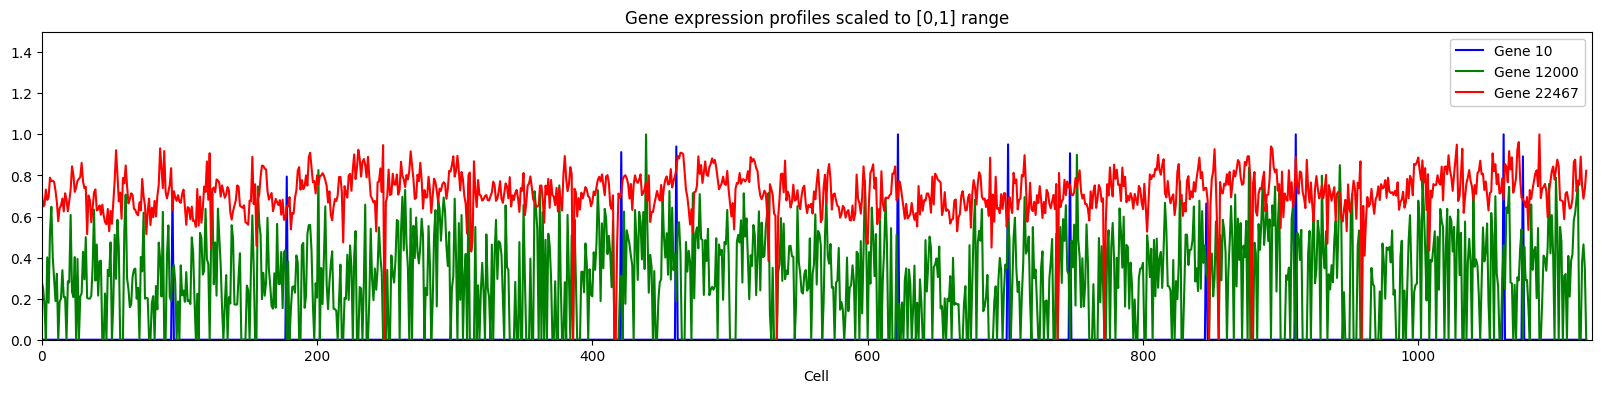

In [13]:
fig, ax = plt.subplots()

fig.set_figheight(4)
fig.set_figwidth(20)

plt.plot(X_scaled[:,10],'b-', label='Gene 10')
plt.plot(X_scaled[:,12000],'g-', label='Gene 12000')
plt.plot(X_scaled[:,22467],'r-', label='Gene 22467')
plt.title('Gene expression profiles scaled to [0,1] range');
ax.legend(loc='upper right', framealpha=1);
plt.xlim([0, 1126])
plt.ylim([0, 1.5])
plt.xlabel('Cell');

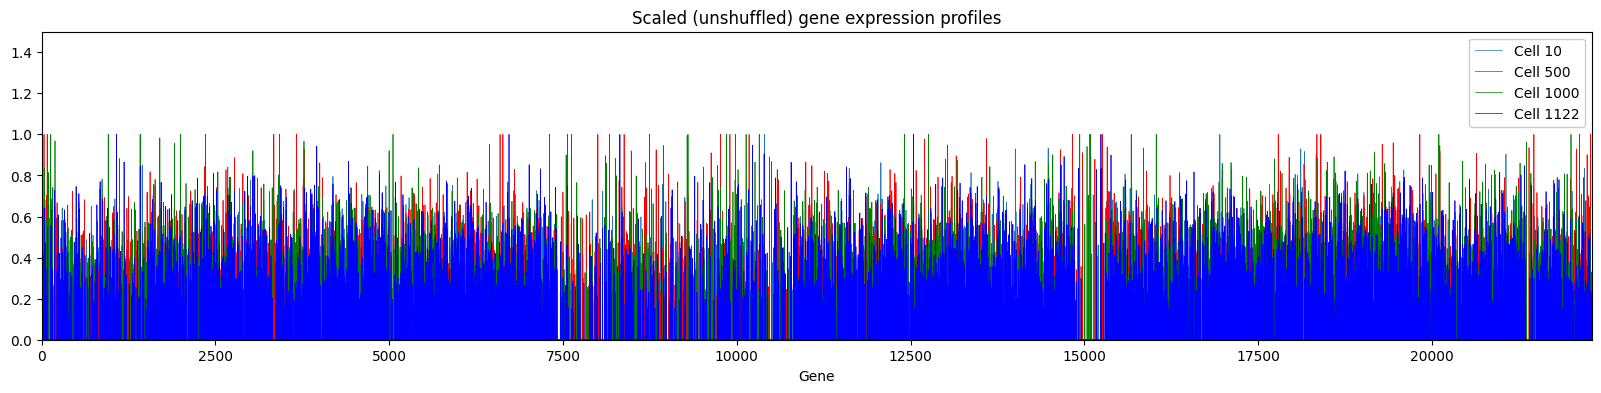

In [14]:
fig, ax = plt.subplots()

fig.set_figheight(4)
fig.set_figwidth(20)

plt.plot(X_scaled[10,:], linewidth=0.5, label='Cell 10')
plt.plot(X_scaled[500,:],'r', linewidth=0.5, label='Cell 500')
plt.plot(X_scaled[1000,:],'g', linewidth=0.5, label='Cell 1000')
plt.plot(X_scaled[1122,:],'b', linewidth=0.5, label='Cell 1122')
plt.title('Scaled (unshuffled) gene expression profiles');
plt.xlabel('Gene')

ax.legend(loc='upper right', framealpha=1);
plt.xlim([0, 22300])
plt.ylim([0, 1.5])
plt.xlabel('Gene');

In [15]:
# data['obsm'].keys()

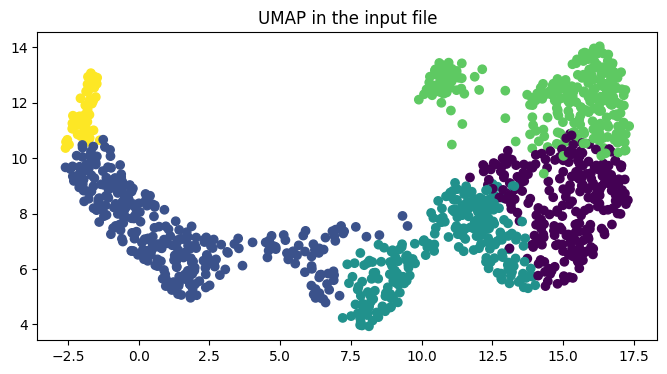

In [16]:
obasm_umap = []

obasm_umap =  data['obsm']['X_umap'][:,:]


fig, ax = plt.subplots()

fig.set_figheight(4)
fig.set_figwidth(8)

plt.scatter(obasm_umap[:, 0], obasm_umap[:, 1], c=data['obs']['cell type']['codes'][:])
plt.title('UMAP in the input file');

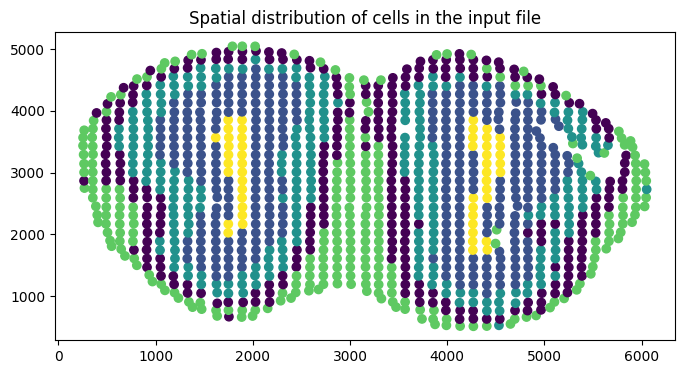

In [17]:
obasm_spatial =  data['obsm']['spatial'][:,:]


fig, ax = plt.subplots()

fig.set_figheight(4)
fig.set_figwidth(8)

plt.scatter(obasm_spatial[:, 0], obasm_spatial[:, 1], c=data['obs']['cell type']['codes'][:])
plt.title('Spatial distribution of cells in the input file');

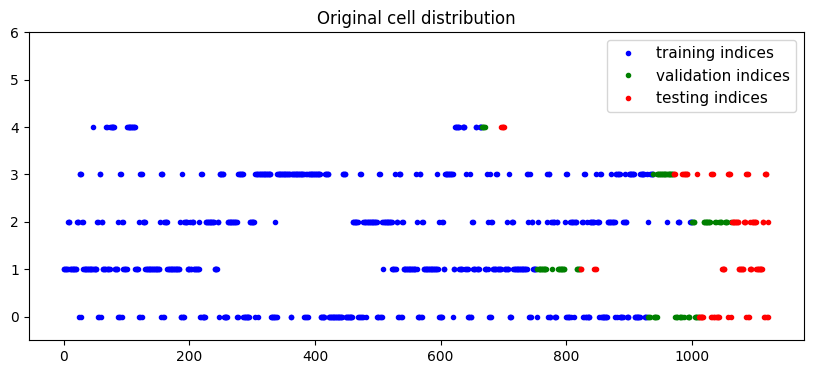

In [39]:
fig, ax = plt.subplots()
fig.set_figheight(4)
fig.set_figwidth(10)

cellF, cell_types = extract_cell_families(data)

original_catIndex = {}

for cat in cellF:
    original_catIndex[cat] = []
    original_catIndex[cat] = np.where(cell_types[0:]==cat)[0]


original_training_indices, original_validation_indices, original_testing_indices, \
original_X_train, original_X_validation, original_X_test = splitData(cellF, original_catIndex)

ax.plot(original_training_indices, cell_types[original_training_indices], 'b.', label='training indices')
ax.plot(original_validation_indices, cell_types[original_validation_indices], 'g.', label='validation indices')
ax.plot(original_testing_indices, cell_types[original_testing_indices], 'r.', label='testing indices')
plt.ylim([-0.5, 6])
plt.legend(fontsize=11);
plt.title('Original cell distribution');

In [19]:
cellF, cell_types = extract_cell_families(data)
sorted(cellF)

X, shuffled_cell_types, catIndex = shuffle_data(X, cell_types, cellF)

training_indices, validation_indices, testing_indices, X_train, X_validation, X_test = splitData(cellF, catIndex)

In [20]:
print("Distribution of cells types")
print("-------------------------------------")
for cat in cellF:
    print("cell type {0}, Whole set:      {1:5d} = {2:5.1f} %".format(cat, len(np.where(shuffled_cell_types[:]==cat)[0]), 
                                                                      100 * len(np.where(shuffled_cell_types[:]==cat)[0])/X.shape[0]))
    print("cell type {0}, Training set:   {1:5d} = {2:5.1f} %".format(cat, len(np.where(shuffled_cell_types[training_indices]==cat)[0]), 
                                                                      100 * len(np.where(shuffled_cell_types[training_indices]==cat)[0])/len(training_indices)))
    print("cell type {0}, Validation set: {1:5d} = {2:5.1f} %".format(cat, len(np.where(shuffled_cell_types[validation_indices]==cat)[0]), 
                                                                      100 * len(np.where(shuffled_cell_types[validation_indices]==cat)[0])/len(validation_indices)))
    print("cell type {0}, Test set:       {1:5d} = {2:5.1f} %".format(cat, len(np.where(shuffled_cell_types[testing_indices]==cat)[0]), 
                                                                      100 * len(np.where(shuffled_cell_types[testing_indices]==cat)[0])/len(testing_indices)))
    print("-------------------------------------")

Distribution of cells types
-------------------------------------
cell type 1, Whole set:        313 =  27.9 %
cell type 1, Training set:     250 =  27.9 %
cell type 1, Validation set:    32 =  27.8 %
cell type 1, Test set:          31 =  27.9 %
-------------------------------------
cell type 2, Whole set:        253 =  22.5 %
cell type 2, Training set:     202 =  22.5 %
cell type 2, Validation set:    26 =  22.6 %
cell type 2, Test set:          25 =  22.5 %
-------------------------------------
cell type 0, Whole set:        253 =  22.5 %
cell type 0, Training set:     202 =  22.5 %
cell type 0, Validation set:    26 =  22.6 %
cell type 0, Test set:          25 =  22.5 %
-------------------------------------
cell type 3, Whole set:        254 =  22.6 %
cell type 3, Training set:     203 =  22.6 %
cell type 3, Validation set:    26 =  22.6 %
cell type 3, Test set:          25 =  22.5 %
-------------------------------------
cell type 4, Whole set:         50 =   4.5 %
cell type 4, Trai

In [21]:
print("X_train_size = {}".format(X_train.shape[0]))
print("X_validation_size = {}".format(X_validation.shape[0]))
print("X_test_size = {}".format(X_test.shape[0]))
print("X_train_size + X_validation_size + X_test_size = {}".format(X_train.shape[0] + X_validation.shape[0] + X_test.shape[0]))

X_train_size = 897
X_validation_size = 115
X_test_size = 111
X_train_size + X_validation_size + X_test_size = 1123


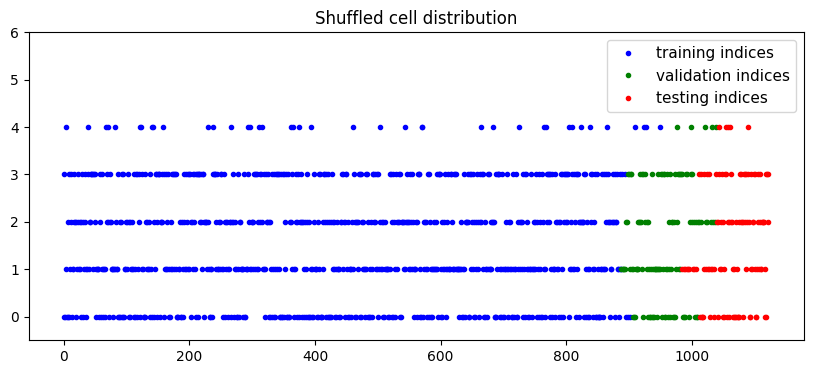

In [40]:
fig, ax = plt.subplots()
fig.set_figheight(4)
fig.set_figwidth(10)

ax.plot(training_indices, shuffled_cell_types[training_indices], 'b.', label='training indices')
ax.plot(validation_indices, shuffled_cell_types[validation_indices], 'g.', label='validation indices')
ax.plot(testing_indices, shuffled_cell_types[testing_indices], 'r.', label='testing indices')
# plt.xlim([600, 800])
plt.ylim([-0.5, 6])

plt.legend(fontsize=11);
plt.title('Shuffled cell distribution');

In [23]:
train_dataset = TensorDataset(X_train, X_train)

data_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                              batch_size=20,
                                              shuffle=True)

In [24]:
class Autoencoder_Linear(nn.Module):
    def __init__(self):
        super().__init__()        
        self.encoder = nn.Sequential(
            nn.Linear(signal_size, 2048), # (22468) -> (N, 2048)
            nn.ReLU(),
            nn.Linear(2048, 32),
            nn.ReLU(),
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(32, 2048),
            nn.ReLU(),
            nn.Linear(2048, signal_size),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [25]:
useGPU = True

# model = Autoencoder()
model = Autoencoder_Linear()
if useGPU:
    model.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=1e-4, 
                             weight_decay=1e-5)

In [26]:
outputs = []
last_epoch = 0

In [28]:
def Train(num_epochs, last_epoch, outputs, data_loader, model, optimizer, criterion, useGPU, X_validation=X_validation, X_test=X_test, stp=5):
    t0 = time.time()

    for epoch in range(num_epochs):
        
        for noisy_cells, cells in data_loader:
            # print(cells.shape)
            if (epoch+1) % stp == 0:
                print(".", end="")
            if useGPU:
                noisy_cells = noisy_cells.to(device)  
                cells = cells.to(device) 
            # print(cells.shape)
            reconstruction = model(noisy_cells)
            loss = criterion(reconstruction, cells)
    
            
            
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
        if useGPU:
            X_validation = X_validation.to(device)
    
        val_reconstruction = model(X_validation)
        val_loss = criterion(val_reconstruction, X_validation)
        
    
        if (epoch+1) % stp == 0:
            print("")
            print(f'Epoch:{epoch+1 + last_epoch}, Loss:{loss.item():.5f}, Val Loss:{val_loss.item():.5f}')    
        # outputs.append((epoch, loss, cell, reconstruction))
        outputs.append((epoch + last_epoch, loss,  val_loss))

    

    last_epoch += num_epochs
    
    t1 = time.time()
    print("\n")
    print("Training completed in {} mins.".format(round((t1 - t0) / 60, 2)))
    print("\n")
    
    if useGPU:
        X_test = X_test.to(device)
    
        test_reconstruction = model(X_test)
        test_loss = criterion(test_reconstruction, X_test)
    
    print(f'Test Loss:{test_loss.item():.5f}')

    # object oriented version should not require return (in general)

    return outputs, reconstruction, noisy_cells, cells, last_epoch

In [59]:
num_epochs = 100
outputs, reconstruction, noisy_cells, cells, last_epoch = Train(num_epochs, last_epoch, outputs, data_loader, model, optimizer, criterion, useGPU)

.............................................
Epoch:205, Loss:0.01676, Val Loss:0.01712
.............................................
Epoch:210, Loss:0.01752, Val Loss:0.01711
.............................................
Epoch:215, Loss:0.01631, Val Loss:0.01713
.............................................
Epoch:220, Loss:0.01801, Val Loss:0.01713
.............................................
Epoch:225, Loss:0.01794, Val Loss:0.01714
.............................................
Epoch:230, Loss:0.01774, Val Loss:0.01712
.............................................
Epoch:235, Loss:0.01775, Val Loss:0.01714
.............................................
Epoch:240, Loss:0.01931, Val Loss:0.01714
.............................................
Epoch:245, Loss:0.01690, Val Loss:0.01717
.............................................
Epoch:250, Loss:0.01666, Val Loss:0.01713
.............................................
Epoch:255, Loss:0.01528, Val Loss:0.01712
................................

In [ ]:
eps = [o[0] for o in outputs]

losses = [t[1].item() for t in outputs]
val_losses = [t[2].item() for t in outputs]

print(len(outputs))

(0.014, 0.025)

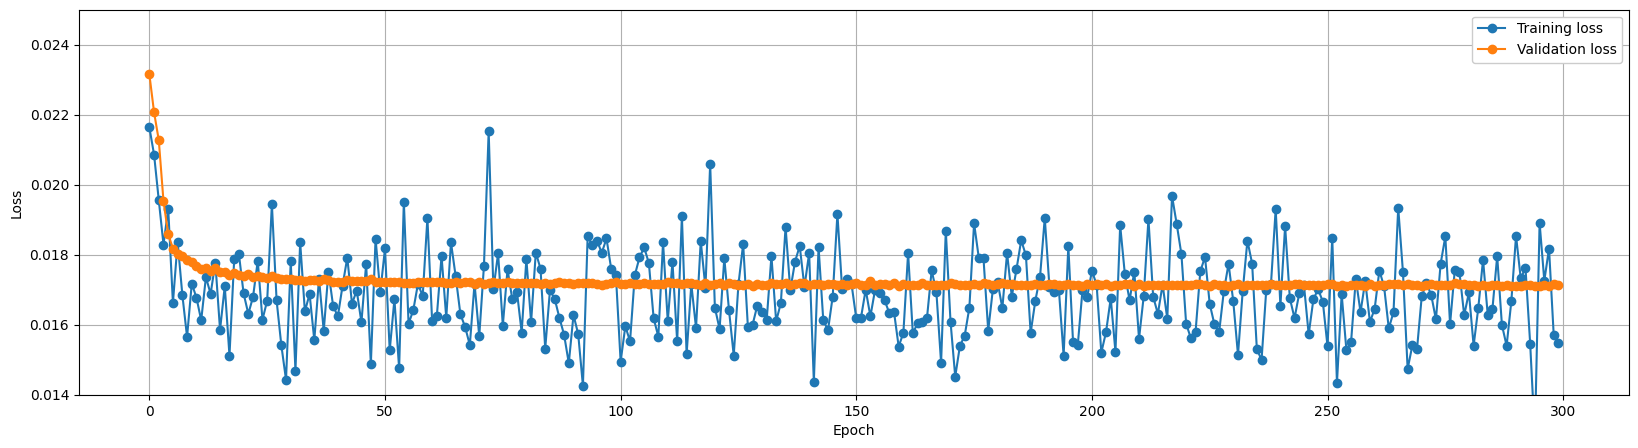

In [77]:
fig, ax = plt.subplots()
fig.set_figheight(5)
fig.set_figwidth(20)

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(eps, losses, 'o-', label='Training loss')
plt.plot(eps, val_losses, 'o-', label='Validation loss')
ax.legend(loc='upper right', framealpha=1);
plt.grid()
plt.ylim([0.014, 0.025])

In [62]:
# val_losses

In [63]:
which_cell = 10

nrec = [r.item() for r in reconstruction[which_cell]]
ncell = [c.item() for c in noisy_cells[which_cell]]

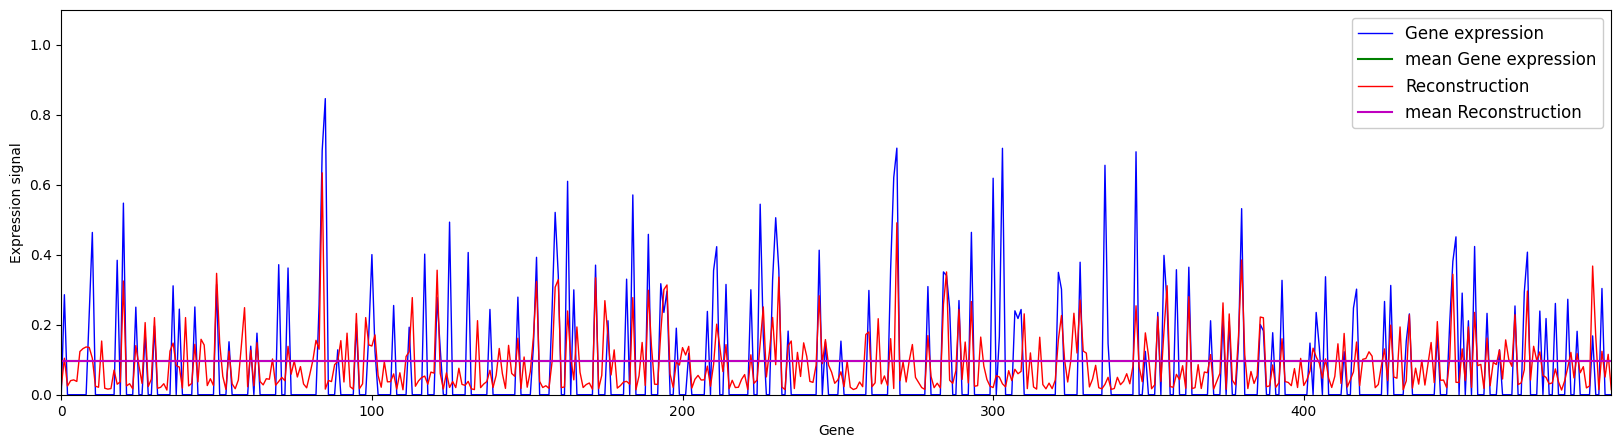

In [70]:
fig, ax = plt.subplots()

fig.set_figheight(5)
fig.set_figwidth(20)


start = 0

ln = 500


genes = [i for i in range(start, start+ln)]

# mean_prediction = [np.mean(predictions) for _ in range(len(predictions[cell,:]))]

mean_prediction = np.full(len(nrec), np.mean(nrec))

mean_test = np.full(len(ncell), np.mean(ncell))

# print(mean_prediction)

ax.plot(genes, ncell[start:start + ln], 'b-', label='Gene expression', linewidth=1)
ax.plot(genes, mean_test[start:start + ln],    'g-', label='mean Gene expression')
ax.plot(genes, nrec[start:start + ln], 'r-', label='Reconstruction', linewidth=1)
ax.plot(genes, mean_prediction[start:start + ln],   'm-', label='mean Reconstruction')
plt.xlabel('Gene')
plt.ylabel('Expression signal')

plt.ylim([0.0, 1.1])
plt.xlim([min(genes), max(genes)])
# plt.title('Cell {0}'.format(which_cell))

ax.legend(loc='upper right', framealpha=1, fontsize=12);

In [55]:
mean_prediction[0] - mean_test[0]

0.0029269956587519436

In [56]:
n_neighbors = 7
min_dist = 1

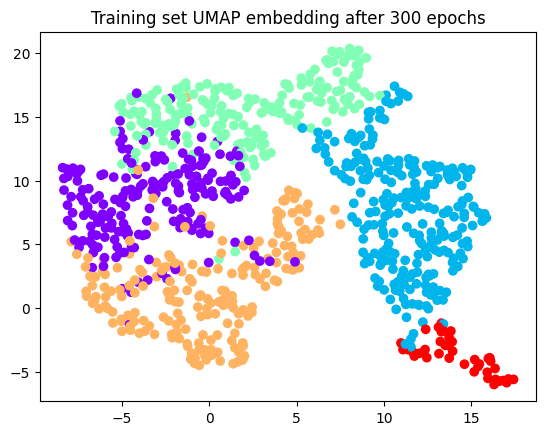

In [74]:
fig, ax = plt.subplots()

# fig.set_figheight(5)
# fig.set_figwidth(5)

X_train_2D_umap = umap_analysis(X_train, n_neighbors, min_dist = min_dist)

plt.scatter(X_train_2D_umap[:,0], X_train_2D_umap[:,1], c=shuffled_cell_types[training_indices], cmap='rainbow')
plt.title('Training set UMAP embedding after {} epochs'.format(last_epoch));

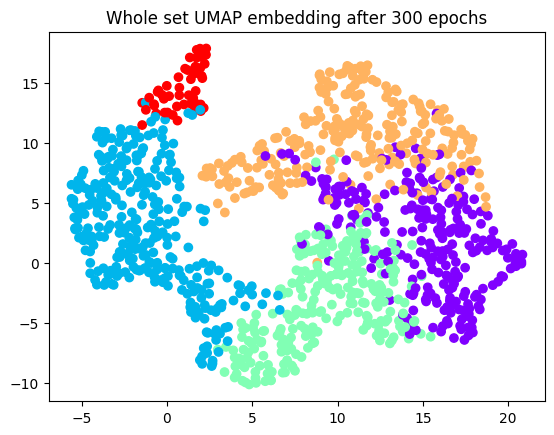

In [98]:
fig, ax = plt.subplots()

# fig.set_figheight(5)
# fig.set_figwidth(5)

X_whole_2D_umap = umap_analysis(X, n_neighbors, min_dist = min_dist)


plt.scatter(X_whole_2D_umap[:,0], X_whole_2D_umap[:,1], c=shuffled_cell_types[:], cmap='rainbow')
plt.title('Whole set UMAP embedding after {} epochs'.format(last_epoch));

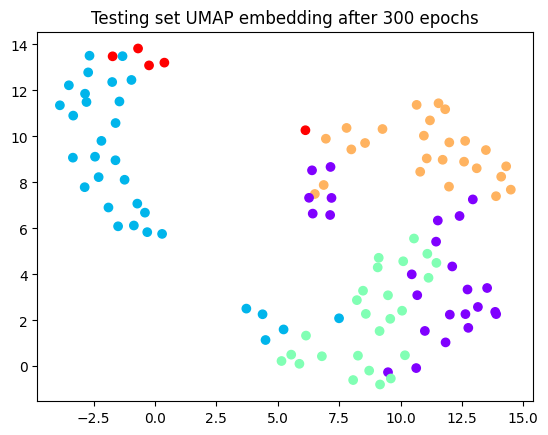

In [99]:
fig, ax = plt.subplots()

# fig.set_figheight(5)
# fig.set_figwidth(5)

X_test_2D_umap = umap_analysis(X_test, n_neighbors, min_dist = min_dist)


plt.scatter(X_test_2D_umap[:,0], X_test_2D_umap[:,1], c=shuffled_cell_types[testing_indices], cmap='rainbow')
plt.title('Testing set UMAP embedding after {} epochs'.format(last_epoch));

In [85]:
def pca(input_X):
    process_X = input_X.to(device)  

    X_embd = model.encoder(process_X)
    X_embd = X_embd.detach().cpu()

    return X_embd

In [86]:
X_embd = pca(X)

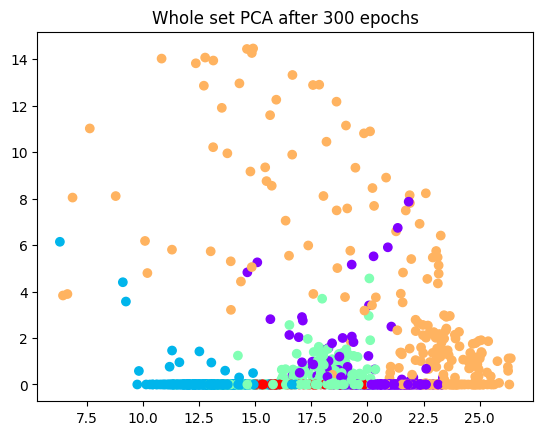

In [87]:
fig, ax = plt.subplots()

plt.scatter(X_embd[:,0], X_embd[:,1], c=shuffled_cell_types[:], cmap='rainbow')
plt.title('Whole set PCA after {} epochs'.format(last_epoch));

In [92]:
X_train_embd = pca(X_train)

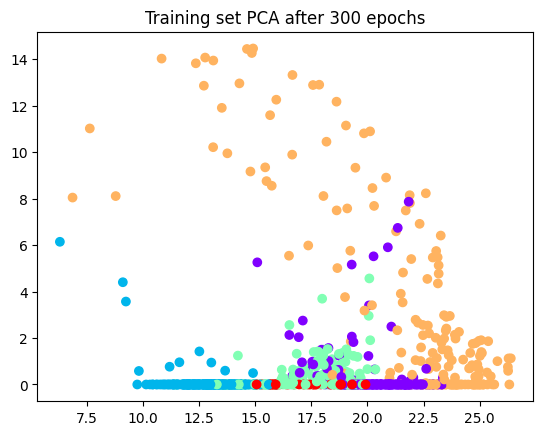

In [94]:
fig, ax = plt.subplots()

plt.scatter(X_train_embd[:,0], X_train_embd[:,1], c=shuffled_cell_types[training_indices], cmap='rainbow')
plt.title('Training set PCA after {} epochs'.format(last_epoch));

In [100]:
X_test_embd = pca(X_test)

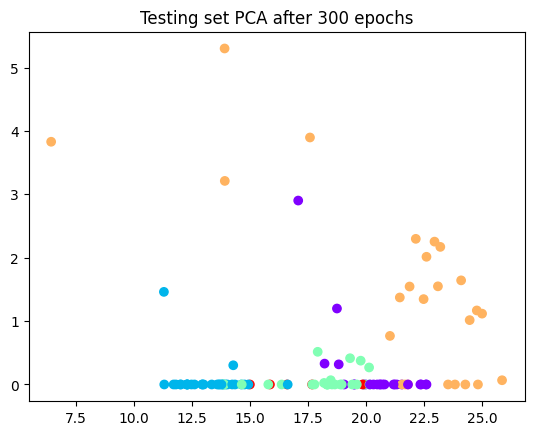

In [102]:
fig, ax = plt.subplots()

plt.scatter(X_test_embd[:,0], X_test_embd[:,1], c=shuffled_cell_types[testing_indices], cmap='rainbow')
plt.title('Testing set PCA after {} epochs'.format(last_epoch));